The following feature engineering methods have been carry-forwarded from the previous notebook.

In [16]:
train=pd.read_csv('TitanicTrain.csv', )
test=pd.read_csv('TitanicTest.csv')
df=pd.concat([train, test], axis=0, sort=True)

In [17]:
df['Title']=df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

In [18]:
mapping={'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',
           'Don': 'Mr', 'Mme': 'Mrs', 'Jonkheer': 'Mr', 'Lady': 'Mrs',
           'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
df.replace({'Title': mapping}, inplace=True)

In [19]:
title_ages=dict(df.groupby('Title')['Age'].median())
df['age_med']=df['Title'].apply(lambda x: title_ages[x])
df['Age'].fillna(df['age_med'], inplace=True, )
del df['age_med']

In [20]:
class_fares=dict(df.groupby('Pclass')['Fare'].median())
df['fare_med']=df['Pclass'].apply(lambda x: class_fares[x])
df['Fare'].fillna(df['fare_med'], inplace=True, )
del df['fare_med']

In [21]:
df['Embarked'].fillna(method='backfill', inplace=True)

In [22]:
train=df[pd.notnull(df['Survived'])]
test=df[pd.isnull(df['Survived'])]

In [23]:
df['Sex']=df['Sex'].astype('category')
df['Sex']=df['Sex'].cat.codes

In [24]:
categorical=['Embarked']

for var in categorical:
    df = pd.concat([df, 
                    pd.get_dummies(df[var], prefix=var)], axis=1)
    del df[var]

In [25]:
categorical=['Title']

for var in categorical:
    df = pd.concat([df, 
                    pd.get_dummies(df[var], prefix=var)], axis=1)
    del df[var]

In [26]:
df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

Now, we will set up the H2O framework to run AutoML and a gradient boosting estimator to assess how well AutoML really performs without specifying any alogrithm.

In [33]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator

from sklearn import metrics
from sklearn.metrics import accuracy_score

import h2o
from h2o.automl import H2OAutoML
h2o.init(max_mem_size='16G')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.211-b12, mixed mode)
  Starting server from C:\Users\Avitrya\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Avitrya\AppData\Local\Temp\tmpuf0tzsbr
  JVM stdout: C:\Users\Avitrya\AppData\Local\Temp\tmpuf0tzsbr\h2o_Avitrya_started_from_python.out
  JVM stderr: C:\Users\Avitrya\AppData\Local\Temp\tmpuf0tzsbr\h2o_Avitrya_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,09 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.6
H2O_cluster_version_age:,19 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_Avitrya_3rrtfs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,14.22 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [35]:
#Converting Pandas dataframes into a format suitable for H2O framework to process

train = h2o.H2OFrame(df[df['Survived'].notna()])
test = h2o.H2OFrame(df[df['Survived'].isna()])

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [38]:
target = 'Survived'
predictors = [f for f in train.columns if f not in ['Survived']]

In [39]:
#Splitting data into training and testing sets

train_df, valid_df, test_df = train.split_frame(ratios=[0.7, 0.15], seed=2018)

In [40]:
#Changing format for H2O framework processing

train_df[target]=train_df[target].asfactor()
valid_df[target]=valid_df[target].asfactor()
test_df[target]=test_df[target].asfactor()

In [41]:
#Checking which features will help in predicting Suvivability

predictors

['Age',
 'Fare',
 'Parch',
 'Pclass',
 'Sex',
 'SibSp',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Title_Dr',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Rev']

In [42]:
#First running the Gradient Boosting Estimator and seeing its accuracy

gbm=H2OGradientBoostingEstimator()

gbm.train(x=predictors, y=target, training_frame=train_df)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [43]:
pred_val=gbm.predict(test_df[predictors])[0].as_data_frame()
pred_val

gbm prediction progress: |████████████████████████████████████████████████| 100%


,predict
0,1
1,1
2,0
3,0
4,1
...,...
110,1
111,0
112,1
113,0


In [44]:
true_val=(test_df[target]).as_data_frame()
acc=accuracy_score(pred_val, true_val)
acc

0.8347826086956521

We got an accuracy of 83.5% from the Gradient Boosting Estimator

In [45]:
#Now, we will run H2O framework's AutoML 

aml=H2OAutoML(max_models=20, seed=1)
aml.train(x=predictors, y=target, training_frame=train_df)

AutoML progress: |
15:45:31.648: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


In [46]:
#This leaderboard displays all the auto-generated models. The best performing model is at the top.

aml.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_grid__1_AutoML_20200701_154531_model_4,0.871413,0.405589,0.851691,0.169176,0.350316,0.122722
GBM_4_AutoML_20200701_154531,0.868669,0.413983,0.849994,0.183306,0.355122,0.126112
GBM_1_AutoML_20200701_154531,0.867578,0.420747,0.831506,0.182924,0.362135,0.131142
StackedEnsemble_BestOfFamily_AutoML_20200701_154531,0.866912,0.398036,0.854523,0.17264,0.348672,0.121572
GBM_3_AutoML_20200701_154531,0.866443,0.417327,0.845559,0.190562,0.358586,0.128584
GLM_1_AutoML_20200701_154531,0.86623,0.417536,0.846619,0.186307,0.361857,0.130941
StackedEnsemble_AllModels_AutoML_20200701_154531,0.866192,0.399152,0.854251,0.17605,0.349378,0.122065
GBM_2_AutoML_20200701_154531,0.864403,0.417557,0.846077,0.192253,0.357592,0.127872
GBM_grid__1_AutoML_20200701_154531_model_1,0.861768,0.412708,0.842458,0.181233,0.356694,0.12723
GBM_grid__1_AutoML_20200701_154531_model_3,0.861746,0.412734,0.846095,0.18246,0.357819,0.128035


In [52]:
#Printing the performance chart of the best performing model

#test1=test
perf=aml.leader.model_performance(test_df)
print(perf)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.12465853534345903
RMSE: 0.35307015640444467
LogLoss: 0.4032070284171383
Mean Per-Class Error: 0.15456821026282852
AUC: 0.884386733416771
AUCPR: 0.8718908434584155
Gini: 0.768773466833542

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42698113670925264: 


,,0,1,Error,Rate
0,0,60.0,8.0,0.1176,(8.0/68.0)
1,1,9.0,38.0,0.1915,(9.0/47.0)
2,Total,69.0,46.0,0.1478,(17.0/115.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.426981,0.817204,42.0
1,max f2,0.257670,0.847107,50.0
2,max f0point5,0.634240,0.837438,35.0
3,max accuracy,0.426981,0.852174,42.0
4,max precision,0.988758,1.000000,0.0
5,max recall,0.051814,1.000000,98.0
6,max specificity,0.988758,1.000000,0.0
7,max absolute_mcc,0.426981,0.693254,42.0
8,max min_per_class_accuracy,0.310535,0.838235,47.0
9,max mean_per_class_accuracy,0.426981,0.845432,42.0



Gains/Lift Table: Avg response rate: 40.87 %, avg score: 40.15 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.017391,0.979928,2.446809,2.446809,1.000000,0.984466,1.000000,0.984466,0.042553,0.042553,144.680851,144.680851,0.042553
1,2,0.026087,0.978339,2.446809,2.446809,1.000000,0.978423,1.000000,0.982451,0.021277,0.063830,144.680851,144.680851,0.063830
2,3,0.034783,0.968980,2.446809,2.446809,1.000000,0.978121,1.000000,0.981369,0.021277,0.085106,144.680851,144.680851,0.085106
3,4,0.043478,0.954488,2.446809,2.446809,1.000000,0.956355,1.000000,0.976366,0.021277,0.106383,144.680851,144.680851,0.106383
4,5,0.060870,0.953020,2.446809,2.446809,1.000000,0.953020,1.000000,0.969696,0.042553,0.148936,144.680851,144.680851,0.148936
5,6,0.104348,0.928535,2.446809,2.446809,1.000000,0.941295,1.000000,0.957862,0.106383,0.255319,144.680851,144.680851,0.255319
6,7,0.156522,0.862909,2.039007,2.310875,0.833333,0.899107,0.944444,0.938277,0.106383,0.361702,103.900709,131.087470,0.346996
7,8,0.217391,0.755818,2.097264,2.251064,0.857143,0.804451,0.920000,0.900806,0.127660,0.489362,109.726444,125.106383,0.459950
8,9,0.304348,0.685532,1.712766,2.097264,0.700000,0.725243,0.857143,0.850645,0.148936,0.638298,71.276596,109.726444,0.564768
9,10,0.400000,0.408970,1.779497,2.021277,0.727273,0.574103,0.826087,0.784515,0.170213,0.808511,77.949710,102.127660,0.690864


In [1]:
acdt=0.9809203142536476
acsvm=0.8428731762065096
acknn=0.8720538720538721
acgnb=0.7802690582959642
aclog=0.8327721661054994
acmnb=0.7174887892376681
acbnb=0.7802690582959642
accnb=0.7309417040358744
aclda=0.8327721661054994
acrf=0.9809203142536476
acrc=0.8327721661054994
acnn=0.8826815485954285
acgbe=0.8347826086956521
acaml=0.852174

In [2]:
ac_scores={
    'DecTree':acdt,
    'SVM':acsvm,
    'KNN':acknn,
    'GaussNBay':acgnb,
    'LogReg':aclog,
    'MultNBay':acmnb,
    'BernNBay':acbnb,
    'CompNBay':accnb,
    'LinearDA':aclda,
    'RandForest':acrf,
    'Ridge':acrc,
    'Neural Network':acnn,
    'Gradient Boosting Estimator':acgbe,
    'AutoML':acaml
}

Text(0.5, 0, 'Accuracy')

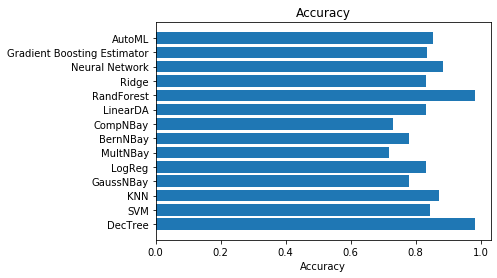

In [3]:
import matplotlib.pyplot as plt

plt.title('Accuracy')
plt.barh(range(len(ac_scores)), list(ac_scores.values()), align='center')
plt.yticks(range(len(ac_scores)), list(ac_scores.keys()))
plt.xlabel('Accuracy')

However, it is important to acknowledge that AutoML has a precision and recall score of 100%

In [4]:
sc={
    'Gradient Boosting Estimator':acgbe,
    'AutoML':acaml
}

Text(0.5, 0, 'Accuracy')

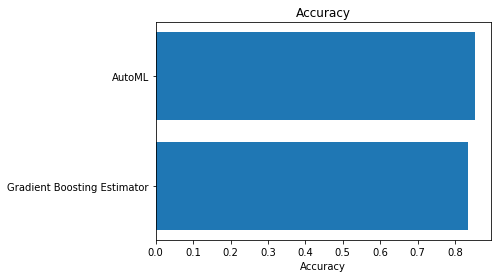

In [6]:
plt.title('Accuracy')
plt.barh(range(len(sc)), list(sc.values()), align='center')
plt.yticks(range(len(sc)), list(sc.keys()))
plt.xlabel('Accuracy')